# Character Recognition

Eksperimen yang dilakukan adalah melakuakn kombinasi antara CTPN dan Text Recognition. CTPN digunakan untuk mendapatkan bounding box yang berisi prediksi posisi text. Text recognition untuk memperoleh text. Digunakan dua buah metode, yaitu Tesseract dan SEE (Semi Supervised End to End). Sebelum gambar diolah Text Recognizer, dilakukan preproses terlebhi dahulu agar meningkatkan akurasi recognition. Ide eksperimen ini mirip dengan ide Faster RCNN yang terdiri dari RPN dan Fast-CNN.

## CTPN (Connectionist Text Proposal Network)

sumber inspirasi: 
- https://arxiv.org/abs/1609.03605
- https://github.com/eragonruan/text-detection-ctpn

In [1]:
from __future__ import print_function

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import _get_blobs
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg
from lib.rpn_msr.proposal_layer_tf import proposal_layer

print(cfg.DATA_DIR)

def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def get_boxes(img, image_name, boxes, scale):
    bbox = []
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        if min_x >= 0 and min_y >= 0 and max_x >= 0 and max_y >= 0 :
            bbox.append([min_x, min_y, max_x, max_y])
    
    return bbox

def draw_boxes(img, image_name, boxes, scale, bbox):
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue
        if box[8] >= 0.9:
            color = (0, 255, 0)
        elif box[8] >= 0.8:
            color = (255, 0, 0)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
        max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
        
        if min_x >= 0 and min_y >= 0 and max_x >= 0 and max_y >= 0 :
            bbox.append([min_x, min_y, max_x, max_y])
        

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)

/character-recognition/data


In [2]:
cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.65
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

In [3]:
im_name = "labelled_image/dress/gaun0.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = get_boxes(img, im_name, boxes, scale)

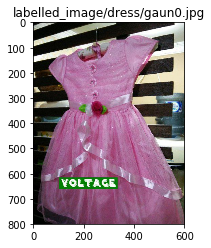

In [4]:
import matplotlib.pyplot as plt
# %matplotlib inline  

# draw image
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(im_name)
plt.imshow(img)

### Get Images from Bounding Box

In [5]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)
#     cv2.imwrite(str(x1) + ".jpg", crop_img)

## EAST (An Efficient and Accurate Scene Text Detector)

Another text detection approach because CTPN take a long time for the detection. The pipeline directly predicts words or text lines of arbitrary orientations and quadrilateral shapes in full images, eliminating unnecessary intermediate steps (e.g., candidate aggregation and word partitioning), with a single neural network. The simplicity of the pipeline allows concentrating efforts on designing loss functions and neural network architecture.
- Paper: https://arxiv.org/abs/1704.03155v2
- Github: https://github.com/argman/EAST 

[NOTE] jika ada error, berarti model belum di download. download model `model.ckpt-49491.data-00000-of-00001` dari https://drive.google.com/file/d/0B3APw5BZJ67ETHNPaU9xUkVoV0U/view dan letakkan pada folder `east_icdar2015_resnet_v1_50_rbox`

In [6]:
import os

import time
import datetime
import cv2
import numpy as np
import uuid
import json

import functools
import logging
import collections

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

logger.info('loading model')
import tensorflow as tf
from east import model
from east.icdar import restore_rectangle
from east import lanms
from east.eval import resize_image, sort_poly, detect

checkpoint_path = "east_icdar2015_resnet_v1_50_rbox/"

input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

f_score, f_geometry = model.model(input_images, is_training=False)

variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
saver = tf.train.Saver(variable_averages.variables_to_restore())

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

ckpt_state = tf.train.get_checkpoint_state(checkpoint_path)
model_path = os.path.join(checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
logger.info('Restore from {}'.format(model_path))
saver.restore(sess, model_path)


@functools.lru_cache(maxsize=1)
def get_host_info():
    ret = {}
    with open('/proc/cpuinfo') as f:
        ret['cpuinfo'] = f.read()

    with open('/proc/meminfo') as f:
        ret['meminfo'] = f.read()

    with open('/proc/loadavg') as f:
        ret['loadavg'] = f.read()

    return ret


def draw_illu(illu, rst):
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        cv2.polylines(illu, [d], isClosed=True, color=(255, 255, 0))
    return illu

def predictor(img):
    start_time = time.time()
    rtparams = collections.OrderedDict()
    rtparams['start_time'] = datetime.datetime.now().isoformat()
    rtparams['image_size'] = '{}x{}'.format(img.shape[1], img.shape[0])
    timer = collections.OrderedDict([
        ('net', 0),
        ('restore', 0),
        ('nms', 0)
    ])

    im_resized, (ratio_h, ratio_w) = resize_image(img)
    rtparams['working_size'] = '{}x{}'.format(
        im_resized.shape[1], im_resized.shape[0])
    start = time.time()
    score, geometry = sess.run(
        [f_score, f_geometry],
        feed_dict={input_images: [im_resized[:,:,::-1]]})
    timer['net'] = time.time() - start

    boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
    logger.info('net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
        timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

    if boxes is not None:
        scores = boxes[:,8].reshape(-1)
        boxes = boxes[:, :8].reshape((-1, 4, 2))
        boxes[:, :, 0] /= ratio_w
        boxes[:, :, 1] /= ratio_h

    duration = time.time() - start_time
    timer['overall'] = duration
    logger.info('[timing] {}'.format(duration))

    text_lines = []
    if boxes is not None:
        text_lines = []
        for box, score in zip(boxes, scores):
            box = sort_poly(box.astype(np.int32))
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                continue
            tl = collections.OrderedDict(zip(
                ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'],
                map(float, box.flatten())))
            tl['score'] = float(score)
            text_lines.append(tl)
    ret = {
        'text_lines': text_lines,
        'rtparams': rtparams,
        'timing': timer,
    }
    ret.update(get_host_info())
    return ret

resnet_v1_50/block1 (?, ?, ?, 256)
resnet_v1_50/block2 (?, ?, ?, 512)
resnet_v1_50/block3 (?, ?, ?, 1024)
resnet_v1_50/block4 (?, ?, ?, 2048)
Shape of f_0 (?, ?, ?, 2048)
Shape of f_1 (?, ?, ?, 512)
Shape of f_2 (?, ?, ?, 256)
Shape of f_3 (?, ?, ?, 64)
Shape of h_0 (?, ?, ?, 2048), g_0 (?, ?, ?, 2048)
Shape of h_1 (?, ?, ?, 128), g_1 (?, ?, ?, 128)
Shape of h_2 (?, ?, ?, 64), g_2 (?, ?, ?, 64)
Shape of h_3 (?, ?, ?, 32), g_3 (?, ?, ?, 32)
INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491


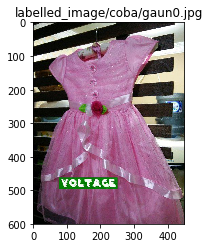

In [7]:
import matplotlib.pyplot as plt

im_name = "labelled_image/coba/gaun0.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax1.set_title(im_name)
plt.imshow(img)
rst = predictor(img)


def get_boxes_east(rst) :
    bbox = []
    for t in rst['text_lines']:
        d = np.array([t['x0'], t['y0'], t['x1'], t['y1'], t['x2'],
                      t['y2'], t['x3'], t['y3']], dtype='int32')
        d = d.reshape(-1, 2)
        min_x = min(d[0][0], d[3][0])
        min_y = min(d[0][1], d[1][1])
        max_x = max(d[1][0], d[2][0])
        max_y = max(d[2][1], d[3][1])
        if min_x >= 0 and min_y >= 0 and max_x >= 0 and max_y >= 0 :
            bbox.append([min_x, min_y, max_x, max_y])
        
    return bbox

bbox = get_boxes_east(rst)

[82, 463, 243, 489]


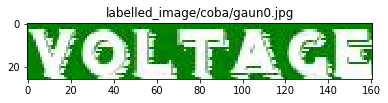

In [8]:
imgs = []
img = cv2.imread(im_name)
for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    print(b)
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)
    
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(im_name)
    plt.imshow(crop_img)

### Perbandingan Waktu Eksekusi CTPN dan EAST

#### Waktu CTPN

In [9]:
import glob
import os
import shutil
import sys
import time

cfg_from_file('ctpn/text.yml')

# init session
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.65
sess = tf.Session(config=config)
with gfile.FastGFile('data/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
sess.run(tf.global_variables_initializer())

input_img = sess.graph.get_tensor_by_name('Placeholder:0')
output_cls_prob = sess.graph.get_tensor_by_name('Reshape_2:0')
output_box_pred = sess.graph.get_tensor_by_name('rpn_bbox_pred/Reshape_1:0')

# import list of images
im_names = glob.glob(os.path.join('labelled_image/', 'coba/*.jpg'))

total = len(im_names)

text_detection_time = 0
count_text_detection = 0

for im_name in im_names:
    start_time = time.time()
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    end_time = time.time()
    text_detection_time += (end_time - start_time)
    count_text_detection += 1
    
print("Total Image = ", total)
print("")
print("Text Detection Time", text_detection_time/count_text_detection)

Total Image =  4

Text Detection Time 1.5788819193840027


#### Waktu EAST

In [10]:
saver.restore(sess, model_path)

# import list of images
im_names = glob.glob(os.path.join('labelled_image/', 'coba/*.jpg'))

total = len(im_names)

text_detection_time = 0
count_text_detection = 0

for im_name in im_names:
    start_time = time.time()
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ret = predictor(img)
    bbox = get_boxes_east(ret)
    end_time = time.time()
    text_detection_time += (end_time - start_time)
    count_text_detection += 1
    
print("Total Image = ", total)
print("")
print("Text Detection Time", text_detection_time/count_text_detection)


INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491
Total Image =  4

Text Detection Time 0.14024919271469116


# Klasifikasi Variasi Text yang ada di Gambar Fashion BL

Text recognition merupakan permasalahan yang cukup kompleks karena banyak sekali variasi dan kasusnya. Setiap permasalahan akan memiliki solusi tersendiri. Sulit menemukan suatu model umum yang dapat digunakan pada text recognition. Kebanyakan metode yang ada menggunakan dataset dari street sign sehingga belum cocok diterapkan di semua kondisi. Ada 2 jenis text yang ada pada gambar data fashion BL:
 - Text natural yang memang berada di objek pada gambar, seperti nama brand
 - Text tambahan pada gambar, seperti info toko, kontak dll

Pada riset ini, akan difokuskan <i>recognition</i> pada text tambahan yang ada pada gambar karena use case awalnya adalah untuk mendeteksi jika Pelapak menambahkan informasi kontak pada gambar.
Setelah dilakukan percobaan pada beberapa gambar, ternyata setiap metode/algoritma memiliki kelebihan dan kekurangan masing-masing sesuai dengan kondisi yang dihadapi. Untuk mempermudah membandingkan <i>robustness</i> dari setiap algoritma, maka dilakukan klasifikasi dari gambar BL. Klasifikasi dilakukan secara manual dengat mata. Diperoleh beberapa jenis yang ada, yaitu:

1. Text normal tipis dengan tambahan background
2. Text normal tebal dengan tambahan background
3. Text normal tanpa tambahan background (biasanya ukuranya pas, tidak terlalu tipis dan tidak terlalu tebal juga)
4. Text yang diberi garis tepi (biasanya tebal)
 

In [11]:
# im_name = "data/fashion_bl/sample_comparation/jenis1/jaket236.jpg"
# img = cv2.imread(im_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
# ax1.set_title("Jenis 1")
# plt.imshow(img)

In [12]:
# im_name = "data/fashion_bl/sample_comparation/jenis2/kemeja1635.jpg"
# img = cv2.imread(im_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
# ax1.set_title("Jenis 2")
# plt.imshow(img)

In [13]:
# im_name = "data/fashion_bl/sample_comparation/jenis3/kacamata418.jpg"
# img = cv2.imread(im_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
# ax1.set_title("Jenis 3")
# plt.imshow(img)

In [14]:
# im_name = "data/fashion_bl/sample_comparation/jenis4/polo1262.jpg"
# img = cv2.imread(im_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
# ax1.set_title("Jenis 4")
# plt.imshow(img)

# Text Recognition

## Tesseract

### Without processing

In [15]:
import tesserocr
from PIL import Image

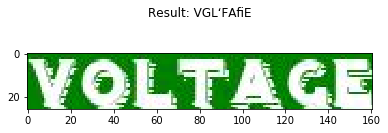

In [16]:
# print(tesserocr.tesseract_version())  # print tesseract-ocr version
# print(tesserocr.get_languages())  # prints tessdata path and list of available languages

for img in imgs :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)

### Resampling

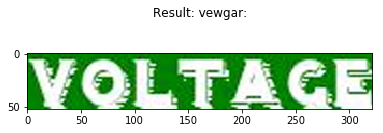

In [17]:
def resampleProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    return img

imgs_copy = imgs
for img in imgs_copy :
    img = resampleProcessor(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img)


### Resampling  + Unsharp

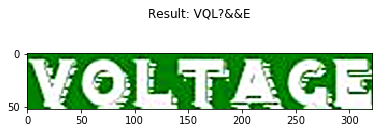

In [18]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    unsharp_image = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)
    img = Image.fromarray(img)
    text = tesserocr.image_to_text(img)  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Otsu Binarization

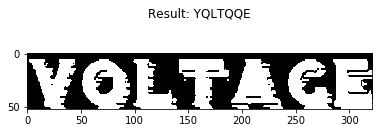

In [19]:
imgs_copy = imgs
for img in imgs_copy :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)
    text = tesserocr.image_to_text(Image.fromarray(img))  # print ocr text from image
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img, 'gray')

### Median Blur

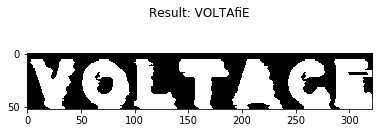

In [20]:
imgs_copy = imgs
for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     img = cv2.bitwise_not(img)
    img = cv2.medianBlur(img, 5)
    text = tesserocr.image_to_text(Image.fromarray(img))  # print ocr text from image
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img, 'gray')

# PyOCR
A Python wrapper for OCR engines (Tesseract, Cuneiform, etc).

[NOTE] Backend PyOCR menggunakan Tesseract, sehingga kebanyakan menghasilkan inferensi yang sama dengan Tesseract.

## To Do List
- [DONE] nyoba2 beberapa filter untuk kasus kata yang berdekatan. dikasih deskripsi kelebihan dan kekurangan untuk setiap eksperimen
- [DONE] validasi text melalui http request
- [DONE] coba preprocessing dengan mencari blob, jika ada yang lebih dari 1/4 luas box, dihilangkan

In [21]:
import pyocr
import pyocr.builders

tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder()

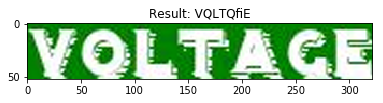

In [22]:
imgs_copy = imgs

for img in imgs_copy :
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = Image.fromarray(img)
    text = tool.image_to_string(
        img,
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    ax1.set_title(title)
    plt.imshow(img)


### Binarization

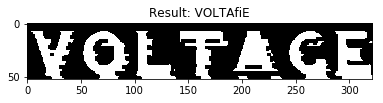

In [23]:
def getBackgroundColor(img) :
    height, width = img.shape
    size = 5
    top_left = img[0:size, 0:size]
    top_right = img[0:size, width-size-1:width-1]
    bottom_left = img[height-size-1:height-1, 0:size]
    bottom_right = img[height-size-1:height-1, width-size-1:width-1]
    colors = [np.median(top_left), np.median(top_right), np.median(bottom_left), np.median(bottom_right)]
#     print(colors)
    return int(np.median(colors))



def binarizationProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    median = np.median(img)
    back_color = getBackgroundColor(img)
#     print(back_color)
    if back_color == 127 :
        if median == 255 :
            img = cv2.bitwise_not(img)
    elif back_color == 255 :
        img = cv2.bitwise_not(img)
        

    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
    return img


imgs_copy = imgs
for img in imgs_copy :
    img = binarizationProcessor(img)
    text = tool.image_to_string(
        Image.fromarray(img),
        lang='eng',
        builder=builder
    )  
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img, 'gray')

### Blob Preprocessing

PR:
- [DONE] seleksi bentuk blob terbesar yang lonjong. referensi = (https://gurus.pyimagesearch.com/lesson-sample-advanced-contour-properties/)

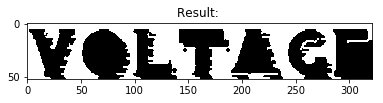

In [24]:
def blobProcessor(img) :
    img = cv2.resize(img, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    img_raw = img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    
    # blob
    median = np.median(img) 
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_outer = []
    contour_inner = []
    
    if len(contours) > 0 :
        max_idx = 0
        max_area = cv2.contourArea(contours[0])
        max_contour = contours[0]
        for i in range(1, len(contours)):
            area = cv2.contourArea(contours[i])
            if area > max_area :
                max_area = area
                max_idx = i

        (x, y, w, h) = cv2.boundingRect(contours[max_idx])
        ratio = float(w)/float(h)
    #     print(ratio)
        for i in range(0, len(contours)):
            if i == max_idx :
                contour_outer.append(contours[i])
            else :
                contour_inner.append(contours[i])
    #     cv2.drawContours(img_raw, contour_list,  -1, (255,0,0), 2)
        if ratio >= 1 :
            if median == 0 :
                cv2.fillPoly(img, pts=contour_outer, color=(0))
                cv2.fillPoly(img, pts=contour_inner, color=(255))
            else :
                cv2.fillPoly(img, pts=contour_outer, color=(255))
                cv2.fillPoly(img, pts=contour_inner, color=(0))
    
    return img

imgs_copy = imgs
for img in imgs_copy :
    img = blobProcessor(img)
    text = tool.image_to_string(
        Image.fromarray(img),
        lang='eng',
        builder=builder
    )
    title = "Result: " + text
    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))
    ax1.set_title(title)
    plt.imshow(img, 'gray')

## (SEE) Semi-Supervised End-to-End Scene Text Recognition

In [25]:
import argparse
import importlib

import os

import json
from collections import OrderedDict

import chainer
from pprint import pprint

import chainer.functions as F
import numpy as np

from PIL import Image
from chainer import configuration

from see.chainer.utils.datatypes import Size

from see.chainer import functions


def get_class_and_module(log_data):
    if not isinstance(log_data, list):
        if 'InverseCompositional' in log_data:
            module_name = 'ic_stn.py'
            klass_name = log_data
        else:
            module_name = 'text_recognition.py'
            klass_name = log_data
    else:
        klass_name, module_name = log_data
    return klass_name, module_name


def load_module(module_file):
    module_spec = importlib.util.spec_from_file_location("models.model", module_file)
    module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(module)
    return module


def build_recognition_net(recognition_net_class, target_shape, args):
    return recognition_net_class(
        target_shape,
        num_rois=args.timesteps,
        label_size=52,
    )


def build_localization_net(localization_net_class, target_shape, args):
    return localization_net_class(
        args.dropout_ratio,
        args.timesteps,
        0,
        target_shape,
        zoom=1.0,
        do_parameter_refinement=False
    )


def build_fusion_net(fusion_net_class, localization_net, recognition_net):
    return fusion_net_class(localization_net, recognition_net)


def create_network(args, log_data):
    # Step 1: build network
    localization_net_class_name, localization_module_name = get_class_and_module(log_data['localization_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, localization_module_name)))
    localization_net_class = eval('module.{}'.format(localization_net_class_name))
    localization_net = build_localization_net(localization_net_class, log_data['target_size'], args)

    recognition_net_class_name, recognition_module_name = get_class_and_module(log_data['recognition_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, recognition_module_name)))
    recognition_net_class = eval('module.{}'.format(recognition_net_class_name))
    recognition_net = build_recognition_net(recognition_net_class, target_shape, args)

    fusion_net_class_name, fusion_module_name = get_class_and_module(log_data['fusion_net'])
    module = load_module(os.path.abspath(os.path.join(args.model_dir, fusion_module_name)))
    fusion_net_class = eval('module.{}'.format(fusion_net_class_name))
    net = build_fusion_net(fusion_net_class, localization_net, recognition_net)

    if args.gpu >= 0:
        net.to_gpu(args.gpu)

    return net


def load_image(image_file, xp, image_size):
    with Image.open(image_file) as the_image:
        the_image = the_image.convert('L')
        the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
        image = xp.asarray(the_image, dtype=np.float32)
        image /= 255
        image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
        return image

def preprocess_image(the_image, xp, image_size) :
    the_image = the_image.convert('L')
    the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
    image = xp.asarray(the_image, dtype=np.float32)
    image /= 255
    image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
    return image

def strip_prediction(predictions, xp, blank_symbol):
    words = []
    for prediction in predictions:
        blank_symbol_seen = False
        stripped_prediction = xp.full((1,), prediction[0], dtype=xp.int32)
        for char in prediction:
            if char == blank_symbol:
                blank_symbol_seen = True
                continue
            if char == stripped_prediction[-1] and not blank_symbol_seen:
                continue
            blank_symbol_seen = False
            stripped_prediction = xp.hstack((stripped_prediction, char.reshape(1, )))
        words.append(stripped_prediction)
    return words


def extract_bbox(bbox, image_size, target_shape, xp):
    bbox.data[...] = (bbox.data[...] + 1) / 2
    bbox.data[0, :] *= image_size.width
    bbox.data[1, :] *= image_size.height

    x = xp.clip(bbox.data[0, :].reshape(target_shape), 0, image_size.width)
    y = xp.clip(bbox.data[1, :].reshape(target_shape), 0, image_size.height)

    top_left = (float(x[0, 0]), float(y[0, 0]))
    bottom_right = (float(x[-1, -1]), float(y[-1, -1]))

    return top_left, bottom_right

In [26]:
args = argparse.ArgumentParser(description="Tool that loads model and predicts on a given image")
args.model_dir = "see/chainer/text_recognition_model/model"
args.snapshot_name = "model_190000.npz"
args.image_path = "data/demo/polo1262.jpg"
args.char_map = "see/chainer/text_recognition_model/small_dataset/ctc_char_map.json"
args.log_name = 'log'
args.dropout_ratio = 0.5
args.blank_symbol = 0
args.gpu = 0
# max number of text regions in the image
args.timesteps = 23
# max number of characters per word
args.num_labels = 1

# open log and extract meta information
with open(os.path.join(args.model_dir, args.log_name)) as the_log:
    log_data = json.load(the_log)[0]

target_shape = Size._make(log_data['target_size'])
image_size = Size._make(log_data['image_size'])

xp = chainer.cuda.cupy if args.gpu >= 0 else np
network = create_network(args, log_data)

# load weights
with np.load(os.path.join(args.model_dir, args.snapshot_name)) as f:
    chainer.serializers.NpzDeserializer(f).load(network)

# load char map
with open(args.char_map) as the_map:
    char_map = json.load(the_map)

# load image
image = load_image(args.image_path, xp, image_size)
with configuration.using_config('train', False):
    predictions, crops, grids = network(image[xp.newaxis, ...])

# extract class scores for each word
words = OrderedDict({})

predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

classification = F.softmax(predictions, axis=2)
classification = classification.data
classification = xp.argmax(classification, axis=2)
classification = xp.transpose(classification, (1, 0))

word = strip_prediction(classification, xp, args.blank_symbol)[0]

word = "".join(map(lambda x: chr(char_map[str(x)]), word))

print(word)

def predict_see(image) :
    image = Image.fromarray(image)
    image = preprocess_image(image, xp, image_size)
    with configuration.using_config('train', False):
        predictions, crops, grids = network(image[xp.newaxis, ...])

    predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

    classification = F.softmax(predictions, axis=2)
    classification = classification.data
    classification = xp.argmax(classification, axis=2)
    classification = xp.transpose(classification, (1, 0))

    word = strip_prediction(classification, xp, args.blank_symbol)[0]

    word = "".join(map(lambda x: chr(char_map[str(x)]), word))

    return word

# bboxes = []
# for bbox in grids[0]:
#     bbox = extract_bbox(bbox, image_size, target_shape, xp)
#     bboxes.append(OrderedDict({
#         'top_left': bbox[0],
#         'bottom_right': bbox[1]
#     }))
# words[word] = bboxes

# # pprint(words)
# for k, v in words.items() :
#     print(k)

teme


# Comparison between SEE and Tesseract

## Per image file

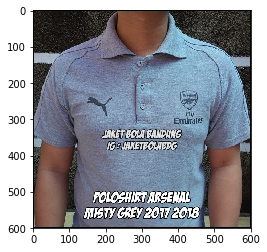

In [27]:
im_name = "data/demo/polo1262.jpg"
img = cv2.imread(im_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
blobs, im_scales = _get_blobs(img, None)
if cfg.TEST.HAS_RPN:
    im_blob = blobs['data']
    blobs['im_info'] = np.array(
        [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
        dtype=np.float32)
cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

scores = rois[:, 0]
boxes = rois[:, 1:5] / im_scales[0]
textdetector = TextDetector()
boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
bbox = get_boxes(img, im_name, boxes, scale)

import matplotlib.pyplot as plt
%matplotlib inline  

# draw image
plt.figure()
plt.imshow(img)

imgs = []
img = cv2.imread(im_name)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for b in bbox :
    y1 = int(b[0]) 
    y2 = int(b[2]) 
    x1 = int(b[1]) 
    x2 = int(b[3]) 
    crop_img = img[x1:x2, y1:y2]
    imgs.append(crop_img)

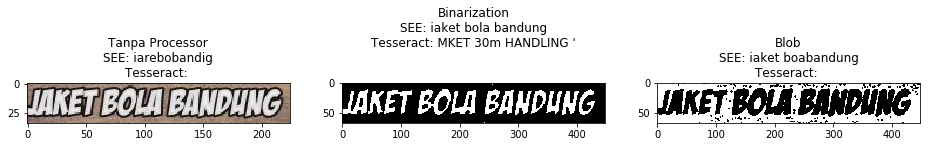

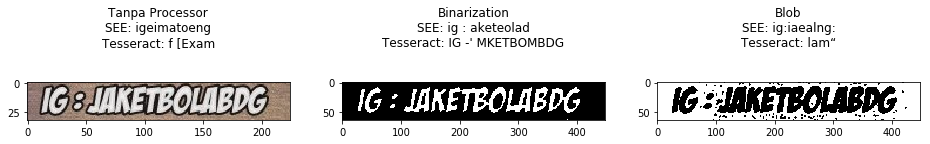

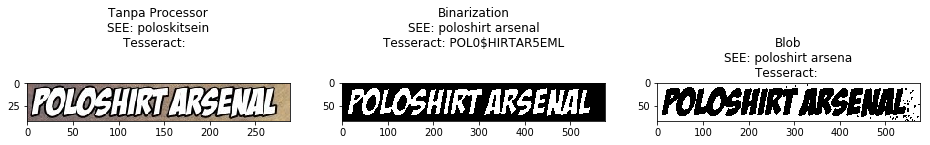

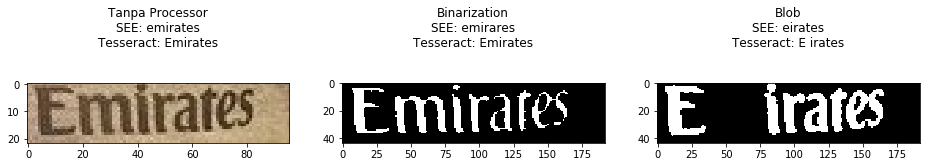

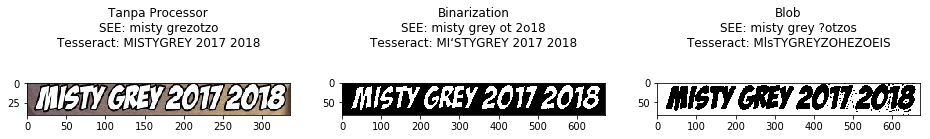

In [28]:
import matplotlib.pyplot as plt

imgs_copy = imgs
for img in imgs_copy :
    img_temp = img
    img_blob = blobProcessor(img_temp)
    img_temp = img
    img_biner = binarizationProcessor(img_temp)
    text_see = predict_see(img)
    text_tesseract = tesserocr.image_to_text(resampleProcessor(img))
    text_tesseract_binarization = tesserocr.image_to_text(Image.fromarray(img_biner))
    text_see_binarization = predict_see(img_biner)
    text_tesseract_blob = tesserocr.image_to_text(Image.fromarray(img_blob))
    text_see_blob = predict_see(img_blob)
    
    plt.figure(figsize=(16,2))
    
    plt.subplot(131)
    plt.imshow(img)
    title_1 = "Tanpa Processor\n" + "SEE: " + text_see + "\nTesseract: " + text_tesseract
    plt.title(title_1)

    plt.subplot(132)
    plt.imshow(img_biner, 'gray')
    title_2 = "Binarization\n" + "SEE: " + text_see_binarization + "\nTesseract: " + text_tesseract_binarization
    plt.title(title_2)

    plt.subplot(133)
    plt.imshow(img_blob, 'gray')
    title_3 = "Blob\n" + "SEE: " + text_see_blob + "\nTesseract: " + text_tesseract_blob
    plt.title(title_3)

    plt.show()

## Perbandingan berdasarkan Jenisnya

### 1. Text normal tipis dengan tambahan background

In [29]:
import glob
import os
import shutil
import sys

# import list of images
im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis1/*.png')) \
        + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis1/*.jpg'))

for im_name in im_names:
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    
    # draw image
    plt.figure()
    plt.imshow(img)

    imgs = []
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    for img in imgs_copy :
        img_blob = blobProcessor(img)
        img_biner = binarizationProcessor(img)
        text_see = predict_see(img)
        text_tesseract = tesserocr.image_to_text(resampleProcessor(img))
        text_tesseract_binarization = tesserocr.image_to_text(Image.fromarray(img_biner))
        text_see_binarization = predict_see(img_biner)
        text_tesseract_blob = tesserocr.image_to_text(Image.fromarray(img_blob))
        text_see_blob = predict_see(img_blob)

        plt.figure(figsize=(16,2))
        
        plt.subplot(131)
        plt.imshow(img)
        title_1 = "Tanpa Processor\n" + "SEE: " + text_see + "\nTesseract: " + text_tesseract
        plt.title(title_1)

        plt.subplot(132)
        plt.imshow(img_biner, 'gray')
        title_2 = "Binarization\n" + "SEE: " + text_see_binarization + "\nTesseract: " + text_tesseract_binarization
        plt.title(title_2)

        plt.subplot(133)
        plt.imshow(img_blob, 'gray')
        title_3 = "Blob\n" + "SEE: " + text_see_blob + "\nTesseract: " + text_tesseract_blob
        plt.title(title_3)

        plt.show()


### 2. Text normal tebal dengan tambahan background

In [30]:
import glob
import os
import shutil
import sys

# import list of images
im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis2/*.png')) \
        + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis2/*.jpg'))

for im_name in im_names:
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    
    # draw image
    plt.figure()
    plt.imshow(img)

    imgs = []
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    for img in imgs_copy :
        img_blob = blobProcessor(img)
        img_biner = binarizationProcessor(img)
        text_see = predict_see(img)
        text_tesseract = tesserocr.image_to_text(resampleProcessor(img))
        text_tesseract_binarization = tesserocr.image_to_text(Image.fromarray(img_biner))
        text_see_binarization = predict_see(img_biner)
        text_tesseract_blob = tesserocr.image_to_text(Image.fromarray(img_blob))
        text_see_blob = predict_see(img_blob)

        plt.figure(figsize=(16,2))
        
        plt.subplot(131)
        plt.imshow(img)
        title_1 = "Tanpa Processor\n" + "SEE: " + text_see + "\nTesseract: " + text_tesseract
        plt.title(title_1)

        plt.subplot(132)
        plt.imshow(img_biner, 'gray')
        title_2 = "Binarization\n" + "SEE: " + text_see_binarization + "\nTesseract: " + text_tesseract_binarization
        plt.title(title_2)

        plt.subplot(133)
        plt.imshow(img_blob, 'gray')
        title_3 = "Blob\n" + "SEE: " + text_see_blob + "\nTesseract: " + text_tesseract_blob
        plt.title(title_3)

        plt.show()


### 3. Text normal tanpa tambahan background (biasanya ukuranya pas, tidak terlalu tipis dan tidak terlalu tebal juga)

In [31]:
import glob
import os
import shutil
import sys

# import list of images
im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis3/*.png')) \
        + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis3/*.jpg'))

for im_name in im_names:
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    
    # draw image
    plt.figure()
    plt.imshow(img)

    imgs = []
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    for img in imgs_copy :
        img_blob = blobProcessor(img)
        img_biner = binarizationProcessor(img)
        text_see = predict_see(img)
        text_tesseract = tesserocr.image_to_text(resampleProcessor(img))
        text_tesseract_binarization = tesserocr.image_to_text(Image.fromarray(img_biner))
        text_see_binarization = predict_see(img_biner)
        text_tesseract_blob = tesserocr.image_to_text(Image.fromarray(img_blob))
        text_see_blob = predict_see(img_blob)

        plt.figure(figsize=(16,2))
        
        plt.subplot(131)
        plt.imshow(img)
        title_1 = "Tanpa Processor\n" + "SEE: " + text_see + "\nTesseract: " + text_tesseract
        plt.title(title_1)

        plt.subplot(132)
        plt.imshow(img_biner, 'gray')
        title_2 = "Binarization\n" + "SEE: " + text_see_binarization + "\nTesseract: " + text_tesseract_binarization
        plt.title(title_2)

        plt.subplot(133)
        plt.imshow(img_blob, 'gray')
        title_3 = "Blob\n" + "SEE: " + text_see_blob + "\nTesseract: " + text_tesseract_blob
        plt.title(title_3)

        plt.show()


### 4. Text yang diberi garis tepi (biasanya tebal)

In [32]:
import glob
import os
import shutil
import sys

# import list of images
im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis4/*.png')) \
        + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', 'sample_comparation/jenis4/*.jpg'))

for im_name in im_names:
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    
    # draw image
    plt.figure()
    plt.imshow(img)

    imgs = []
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    for img in imgs_copy :
        img_blob = blobProcessor(img)
        img_biner = binarizationProcessor(img)
        text_see = predict_see(img)
        text_tesseract = tesserocr.image_to_text(resampleProcessor(img))
        text_tesseract_binarization = tesserocr.image_to_text(Image.fromarray(img_biner))
        text_see_binarization = predict_see(img_biner)
        text_tesseract_blob = tesserocr.image_to_text(Image.fromarray(img_blob))
        text_see_blob = predict_see(img_blob)

        plt.figure(figsize=(16,2))
        
        plt.subplot(131)
        plt.imshow(img)
        title_1 = "Tanpa Processor\n" + "SEE: " + text_see + "\nTesseract: " + text_tesseract
        plt.title(title_1)

        plt.subplot(132)
        plt.imshow(img_biner, 'gray')
        title_2 = "Binarization\n" + "SEE: " + text_see_binarization + "\nTesseract: " + text_tesseract_binarization
        plt.title(title_2)

        plt.subplot(133)
        plt.imshow(img_blob, 'gray')
        title_3 = "Blob\n" + "SEE: " + text_see_blob + "\nTesseract: " + text_tesseract_blob
        plt.title(title_3)

        plt.show()


## Perbandingan Akurasi  & Execution Time dari Text Recognition dengan Labelled BL Image, Text Detection dengan EAST

In [33]:
saver.restore(sess, model_path)


# import list of images
im_names = glob.glob(os.path.join('labelled_image/', '*/*.jpg'))

total = len(im_names)

count_see = 0
count_tesseract = 0
count_see_binarization = 0
count_tesseract_binarization = 0
count_see_blob = 0
count_tesseract_blob = 0

text_detection_time = 0
count_text_detection = 0

count_text_recognition = 0
see_time = 0
tesseract_time = 0
see_binarization_time = 0
tesseract_binarization_time = 0
see_blob_time = 0
tesseract_blob_time = 0

for im_name in im_names:
#     print(im_name)
    start_time = time.time()
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ret = predictor(img)
    bbox = get_boxes_east(ret)
    end_time = time.time()
    text_detection_time += (end_time - start_time)
    count_text_detection += 1
#     print(bbox)
    
    # draw image
#     plt.figure()
#     plt.imshow(img)

    imgs = [] 
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    text_see = ""
    text_tesseract = ""
    text_see_binarization = ""
    text_tesseract_binarization = ""
    text_see_blob = ""
    text_tesseract_blob = ""
    for img in imgs_copy :
        count_text_recognition += 1
        start_time = time.time()
        img_blob = blobProcessor(img)
        end_time = time.time()
        blob_process_time = end_time - start_time
        start_time = time.time()
        img_biner = binarizationProcessor(img)
        end_time = time.time()
        binarization_process_time = end_time - start_time
        
        start_time = time.time()
        text_see_prediction = predict_see(img)
        end_time = time.time() 
        see_time += end_time - start_time
        if len(text_see_prediction) >= len(text_see) :
            text_see = text_see_prediction
        
        start_time = time.time()
        text_tesseract_prediction = tesserocr.image_to_text(resampleProcessor(img))
        end_time = time.time()
        tesseract_time += end_time - start_time
        if len(text_tesseract_prediction) >= len(text_tesseract) :
            text_tesseract = text_tesseract_prediction
        
        start_time = time.time()
        text_tesseract_binarization_prediction = tesserocr.image_to_text(Image.fromarray(img_biner))
        end_time = time.time()
        tesseract_binarization_time += end_time - start_time + binarization_process_time 
        if len(text_tesseract_binarization_prediction) >= len(text_tesseract_binarization) :
            text_tesseract_binarization = text_tesseract_binarization_prediction
        
        start_time = time.time()
        text_see_binarization_prediction = predict_see(img_biner)
        end_time = time.time()
        see_binarization_time += end_time - start_time + binarization_process_time
        if len(text_see_binarization_prediction) >= len(text_see_binarization) :
            text_see_binarization = text_see_binarization_prediction
        
        start_time = time.time()
        text_tesseract_blob_prediction = tesserocr.image_to_text(Image.fromarray(img_blob))
        end_time = time.time()
        tesseract_blob_time += end_time - start_time + blob_process_time
        if len(text_tesseract_blob_prediction) >= len(text_tesseract_blob) :
            text_tesseract_blob = text_tesseract_blob_prediction
        
        start_time = time.time()
        text_see_blob_prediction = predict_see(img_blob)
        end_time = time.time()
        see_blob_time += end_time - start_time + blob_process_time
        if len(text_see_blob_prediction) >= len(text_see_blob) :
            text_see_blob = text_see_blob_prediction
    
    text_see = text_see.lower()
    text_tesseract = text_tesseract.lower()
    text_see_binarization = text_see_binarization.lower()
    text_tesseract_binarization = text_tesseract_binarization.lower()
    text_see_blob = text_see_blob.lower()
    text_tesseract_blob = text_tesseract_blob.lower()

#     print(text_see)
#     print(text_tesseract)
#     print(text_see_binarization)
#     print(text_tesseract_binarization)
#     print(text_see_blob)
#     print(text_tesseract_blob)
    
    filename = im_name.split('.')[0] + ".txt"
    file = open(filename, "r") 
    line = file.read()
    text = line.split(',')[-1]
    text = text.lower()
#     print(text)
    
    if text_see in text or text in text_see :
        count_see += 1
    
    if text_tesseract in text or text in text_tesseract :
        count_tesseract += 1
        
    if text_see_binarization in text or text in text_see_binarization :
            count_see_binarization += 1
    
    if text_tesseract_binarization in text or text in text_tesseract_binarization :
        count_tesseract_binarization += 1
        
    if text_see_blob in text or text in text_see_blob :
        count_see_blob += 1
        
    if text_tesseract_blob in text or text in text_tesseract_blob :
        count_tesseract_blob += 1
        
print("Total Image = ", total)
print("See Prediction Accuray = ", 100.00 * float(count_see) / float(total))
print("Tesseract Prediction Accuray = ", 100.00 * float(count_tesseract) / float(total))
print("See Binarization Prediction Accuray = ", 100.00 * float(count_see_binarization) / float(total))
print("Tesseract Binarization Prediction Accuray = ", 100.00 * float(count_tesseract_binarization) / float(total))
print("See Blob Prediction Accuray = ", 100.00 * float(count_see_blob) / float(total))
print("Tesseract Blob Prediction Accuray = ", 100.00 * float(count_tesseract_blob) / float(total))

print("")
print("Text Detection Time", text_detection_time/count_text_detection)
print("See Recognition Time: ", see_time/count_text_recognition)
print("Tesseract Recognition Time: ", tesseract_time/count_text_recognition)
print("See Binarization Recognition Time: ", see_binarization_time/count_text_recognition)
print("Tesseract Binarization Recognition Time: ", tesseract_binarization_time/count_text_recognition)
print("See Blob Recognition Time: ", see_blob_time/count_text_recognition)
print("Tesseract Blob Recognition Time: ", tesseract_blob_time/count_text_recognition)

INFO:tensorflow:Restoring parameters from east_icdar2015_resnet_v1_50_rbox/model.ckpt-49491
Total Image =  1377
See Prediction Accuray =  77.5599128540305
Tesseract Prediction Accuray =  58.31517792302106
See Binarization Prediction Accuray =  74.07407407407408
Tesseract Binarization Prediction Accuray =  77.19680464778504
See Blob Prediction Accuray =  63.68917937545388
Tesseract Blob Prediction Accuray =  78.14088598402324

Text Detection Time 0.03748770459631516
See Recognition Time:  0.06834280235540754
Tesseract Recognition Time:  0.17994530836102793
See Binarization Recognition Time:  0.06475758951511408
Tesseract Binarization Recognition Time:  0.15498076449117187
See Blob Recognition Time:  0.06371157523618645
Tesseract Blob Recognition Time:  0.1464733873186022


## Perbandingan Akurasi  & Execution Time dari Text Recognition dengan Labelled BL Image, Text Detection dengan CTPN

In [34]:
import glob
import os
import shutil
import sys
import time


# import list of images
im_names = glob.glob(os.path.join('labelled_image/', '*/*.jpg'))

total = len(im_names)

count_see = 0
count_tesseract = 0
count_see_binarization = 0
count_tesseract_binarization = 0
count_see_blob = 0
count_tesseract_blob = 0

text_detection_time = 0
count_text_detection = 0

count_text_recognition = 0
see_time = 0
tesseract_time = 0
see_binarization_time = 0
tesseract_binarization_time = 0
see_blob_time = 0
tesseract_blob_time = 0

for im_name in im_names:
    start_time = time.time()
    img = cv2.imread(im_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    blobs, im_scales = _get_blobs(img, None)
    if cfg.TEST.HAS_RPN:
        im_blob = blobs['data']
        blobs['im_info'] = np.array(
            [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
            dtype=np.float32)
    cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
    rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

    scores = rois[:, 0]
    boxes = rois[:, 1:5] / im_scales[0]
    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    bbox = get_boxes(img, im_name, boxes, scale)
    end_time = time.time()
    text_detection_time += (end_time - start_time)
    count_text_detection += 1
    
    # draw image
#     plt.figure()
#     plt.imshow(img)

    imgs = [] 
    
    img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for b in bbox :
        y1 = int(b[0]) 
        y2 = int(b[2]) 
        x1 = int(b[1]) 
        x2 = int(b[3]) 
        crop_img = img[x1:x2, y1:y2]
        imgs.append(crop_img)
    
    imgs_copy = imgs
    text_see = ""
    text_tesseract = ""
    text_see_binarization = ""
    text_tesseract_binarization = ""
    text_see_blob = ""
    text_tesseract_blob = ""
    for img in imgs_copy :
        count_text_recognition += 1
        start_time = time.time()
        img_blob = blobProcessor(img)
        end_time = time.time()
        blob_process_time = end_time - start_time
        start_time = time.time()
        img_biner = binarizationProcessor(img)
        end_time = time.time()
        binarization_process_time = end_time - start_time
        
        start_time = time.time()
        text_see_prediction = predict_see(img)
        end_time = time.time() 
        see_time += end_time - start_time
        if len(text_see_prediction) >= len(text_see) :
            text_see = text_see_prediction
        
        start_time = time.time()
        text_tesseract_prediction = tesserocr.image_to_text(resampleProcessor(img))
        end_time = time.time()
        tesseract_time += end_time - start_time
        if len(text_tesseract_prediction) >= len(text_tesseract) :
            text_tesseract = text_tesseract_prediction
        
        start_time = time.time()
        text_tesseract_binarization_prediction = tesserocr.image_to_text(Image.fromarray(img_biner))
        end_time = time.time()
        tesseract_binarization_time += end_time - start_time + binarization_process_time 
        if len(text_tesseract_binarization_prediction) >= len(text_tesseract_binarization) :
            text_tesseract_binarization = text_tesseract_binarization_prediction
        
        start_time = time.time()
        text_see_binarization_prediction = predict_see(img_biner)
        end_time = time.time()
        see_binarization_time += end_time - start_time + binarization_process_time
        if len(text_see_binarization_prediction) >= len(text_see_binarization) :
            text_see_binarization = text_see_binarization_prediction
        
        start_time = time.time()
        text_tesseract_blob_prediction = tesserocr.image_to_text(Image.fromarray(img_blob))
        end_time = time.time()
        tesseract_blob_time += end_time - start_time + blob_process_time
        if len(text_tesseract_blob_prediction) >= len(text_tesseract_blob) :
            text_tesseract_blob = text_tesseract_blob_prediction
        
        start_time = time.time()
        text_see_blob_prediction = predict_see(img_blob)
        end_time = time.time()
        see_blob_time += end_time - start_time + blob_process_time
        if len(text_see_blob_prediction) >= len(text_see_blob) :
            text_see_blob = text_see_blob_prediction
    
    text_see = text_see.lower()
    text_tesseract = text_tesseract.lower()
    text_see_binarization = text_see_binarization.lower()
    text_tesseract_binarization = text_tesseract_binarization.lower()
    text_see_blob = text_see_blob.lower()
    text_tesseract_blob = text_tesseract_blob.lower()

#     print(text_see)
#     print(text_tesseract)
#     print(text_see_binarization)
#     print(text_tesseract_binarization)
#     print(text_see_blob)
#     print(text_tesseract_blob)
    
    filename = im_name.split('.')[0] + ".txt"
    file = open(filename, "r") 
    line = file.read()
    text = line.split(',')[-1]
    text = text.lower()
#     print(text)
    
    if text_see in text or text in text_see :
        count_see += 1
    
    if text_tesseract in text or text in text_tesseract :
        count_tesseract += 1
        
    if text_see_binarization in text or text in text_see_binarization :
            count_see_binarization += 1
    
    if text_tesseract_binarization in text or text in text_tesseract_binarization :
        count_tesseract_binarization += 1
        
    if text_see_blob in text or text in text_see_blob :
        count_see_blob += 1
        
    if text_tesseract_blob in text or text in text_tesseract_blob :
        count_tesseract_blob += 1
        
print("Total Image = ", total)
print("See Prediction Accuray = ", 100.00 * float(count_see) / float(total))
print("Tesseract Prediction Accuray = ", 100.00 * float(count_tesseract) / float(total))
print("See Binarization Prediction Accuray = ", 100.00 * float(count_see_binarization) / float(total))
print("Tesseract Binarization Prediction Accuray = ", 100.00 * float(count_tesseract_binarization) / float(total))
print("See Blob Prediction Accuray = ", 100.00 * float(count_see_blob) / float(total))
print("Tesseract Blob Prediction Accuray = ", 100.00 * float(count_tesseract_blob) / float(total))

print("")
print("Text Detection Time", text_detection_time/count_text_detection)
print("See Recognition Time: ", see_time/count_text_recognition)
print("Tesseract Recognition Time: ", tesseract_time/count_text_recognition)
print("See Binarization Recognition Time: ", see_binarization_time/count_text_recognition)
print("Tesseract Binarization Recognition Time: ", tesseract_binarization_time/count_text_recognition)
print("See Blob Recognition Time: ", see_blob_time/count_text_recognition)
print("Tesseract Blob Recognition Time: ", tesseract_blob_time/count_text_recognition)

Total Image =  1377
See Prediction Accuray =  69.64415395787945
Tesseract Prediction Accuray =  57.80682643427741
See Binarization Prediction Accuray =  68.55482933914307
Tesseract Binarization Prediction Accuray =  72.76688453159042
See Blob Prediction Accuray =  65.14161220043573
Tesseract Blob Prediction Accuray =  71.16920842411038

Text Detection Time 1.3326848498616604
See Recognition Time:  0.06424536566633458
Tesseract Recognition Time:  0.17782889512508185
See Binarization Recognition Time:  0.06701667954988569
Tesseract Binarization Recognition Time:  0.15770094299691684
See Blob Recognition Time:  0.06535196022863055
Tesseract Blob Recognition Time:  0.1569523749184972


# Information Extraction

Pada tahap ini dilakukan eksperimen untuk mengetahui apakah di dalam text yang ada terdapat informasi seperti kontak HP, id bbm, id line, dll.

### Kontak HP

Deteksi dilakukan menggunakan regex

In [35]:
import re

def isContainHP(text) :
    # preprocess
    # remove some symbol
    text = text.translate('-\'.() !@#')
    print(text)
    result = re.match("[0]\d{9,11}|[+]\d{12,14}", text)
    if result :
        print(result.group(0))
        return True
    else :
        return False

text = "09342.31.32.33"
print(isContainHP(text))

09342.31.32.33
False


### Validasi melalui akun media sosial
Menggunakan HTTP Request dan mengecek status code

#### Twitter

In [36]:
import urllib

def isValidUserTwitter(username) :

    url = "https://twitter.com/" + username
    try: 
        status = urllib.request.urlopen(url).getcode()
    except urllib.request.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200


username = "mhilmiasyrofi"
print(isValidUserTwitter(username))

True


#### Instagram

In [37]:
def isValidUserInstagram(username) :
    url = "https://www.instagram.com/" + username + "/"
    try: 
        status = urllib.request.urlopen(url).getcode()
    except urllib.request.HTTPError as err:
        if err.code == 404:
    #         print("No User Found")
            status = 404
        else:
            raise
    return status == 200
    
username = "avnusavas"
print(isValidUserInstagram(username))

False


# Eksperimen Dengan Banyak Gambar

[NOTE] ada sekitar 21000, dibutuhkan waktu yang lama

In [38]:
# import glob
# import os
# import shutil
# import sys

# # import list of images
# im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', '*/*.png')) \
#         + glob.glob(os.path.join(cfg.DATA_DIR, 'fashion_bl/', '*/*.jpg'))

# results_sample = []
# for im_name in im_names:
#     img = cv2.imread(im_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_copy = img
#     img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
#     blobs, im_scales = _get_blobs(img, None)
#     if cfg.TEST.HAS_RPN:
#         im_blob = blobs['data']
#         blobs['im_info'] = np.array(
#             [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
#             dtype=np.float32)
#     cls_prob, box_pred = sess.run([output_cls_prob, output_box_pred], feed_dict={input_img: blobs['data']})
#     rois, _ = proposal_layer(cls_prob, box_pred, blobs['im_info'], 'TEST', anchor_scales=cfg.ANCHOR_SCALES)

#     scores = rois[:, 0]
#     boxes = rois[:, 1:5] / im_scales[0]
#     textdetector = TextDetector()
#     boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
#     bbox = []
#     draw_boxes(img, im_name, boxes, scale, bbox)

#     texts = []
#     imgs = []

#     for b in bbox :
#         y1 = int(b[0]) 
#         y2 = int(b[2]) 
#         x1 = int(b[1]) 
#         x2 = int(b[3]) 
#         crop_img = img[x1:x2, y1:y2]
#         imgs.append(crop_img)

#     for img in imgs :
#         text, img = binarizationProcessor(img)
#         if text != "" :
#             texts.append(text)
# #                 if text[0] == '@' :
# #                     text = text[1:len(text)]
# #                     if isValidUserTwitter(text) or isValidUserInstagram(text) :
# #                         results.append({"Image" : img, "Text" : text, "Name" : im_name})
# #                 elif isContainHP(text) :
# #                     results.append({"Image" : img, "Text" : text, "Name" : im_name})
#     results_sample.append(texts)


In [39]:
# print(results_sample)